In [1]:
import numpy as np
import jax.numpy as jnp
import jax as jax
import matplotlib.pyplot as plt
from colorsys import hls_to_rgb
import matplotlib.pyplot as plt
from jax.numpy import pi
import chromatix
from chromatix.utils.shapes import _broadcast_2d_to_spatial
import chromatix.functional as cx

In [2]:
# CC nadapez: from https://stackoverflow.com/a/20958684
def colorize(field, normalize=True, gamma=0.3):
    z = field.u[0,:,:,0,0]
    r = np.abs(z)
    if normalize:
        r = r / np.max(r)

    arg = np.angle(z) 

    h = (arg + pi)  / (2 * pi) + 0.5
    l = 1.0 - 1.0/(1.0 + r**gamma)
    s = 0.8

    c = np.vectorize(hls_to_rgb) (h,l,s) # --> tuple
    c = np.array(c)  # -->  array of (3,n,m) shape, but need (n,m,3)
    c = c.swapaxes(0,2) 
    c = c.swapaxes(0,1) 
    return c

## Scalable Angular Spectrum (SAS) propagation applied to a Gabor inline hologram

A scattering sample (here a rectangular aperture) is illuminated by a spherically expanding wave and the diffraction pattern is recorded at a distant detector

In [23]:
N_box = 512 # sampling points along the width
L_box = 128 # width of the initial field to calculate on in µm
source_distance = 200.0 # distance of the source from the sample
detector_distance = 1024.0 # distance of the detector from the sample
lbd = 0.5
shape = (N_box, N_box)
kx =  2 * jnp.pi / lbd * np.sin(20/ 360 * 2 * jnp.pi)

field_sample = cx.point_source(shape=shape, dx=L_box/N_box, spectrum=lbd, spectral_density=1.0, z=source_distance, n=1.0)
# field_sample = cx.plane_wave(shape=shape, dx=L_box/N_box, spectrum=lbd, spectral_density=1.0, kykx=[0,kx]) / 0.0078125

D_box = L_box / 16

# field_exit = cx.square_pupil(field_sample, w=D_box)
field_exit = field_sample * jnp.array(_broadcast_2d_to_spatial(chromatix.utils.data.siemens_star(field_sample.spatial_shape[0], num_spokes=16, radius=[150,190]), field_sample.ndim))

field_sensor = cx.propagation.transform_propagate_sas(field_exit, z=detector_distance, n=1.0, skip_final_phase=True)

field_sensor_fr = cx.propagation.transform_propagate(field_exit, z=detector_distance, n=1.0, N_pad=(256,256), skip_final_phase=True)
field_bwd = cx.propagation.transform_propagate(field_sensor_fr, z=-detector_distance, n=1.0, N_pad=(256,256), skip_initial_phase=True)


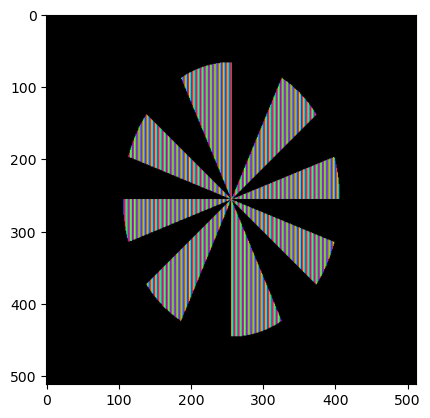

In [24]:
plt.imshow(colorize(field_exit))

[1.9999999 1.9999999]


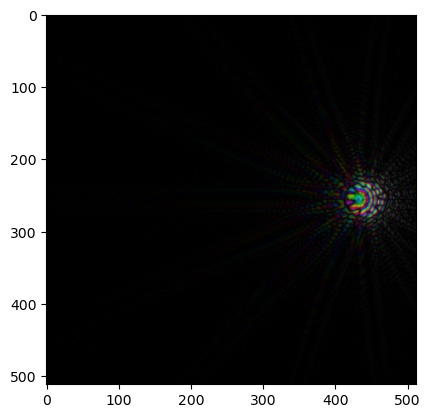

In [25]:
print(np.squeeze(field_sensor.dx))
plt.imshow(colorize(field_sensor, gamma=1.0))


[0.25 0.25]


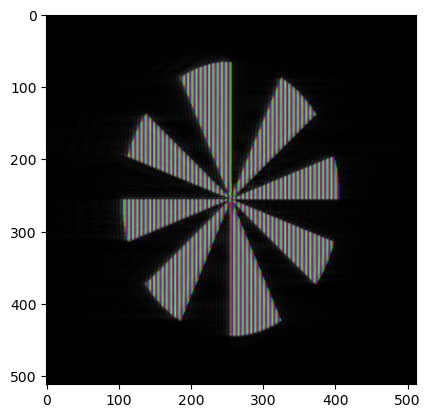

In [26]:
# inverse SAS

field_backpropagated = cx.propagation.transform_propagate_sas(field_sensor, z= -detector_distance, n=1.0, skip_initial_phase=True, inverse=True)
print(np.squeeze(field_backpropagated.dx))
plt.imshow(colorize(field_backpropagated, gamma=1.0))

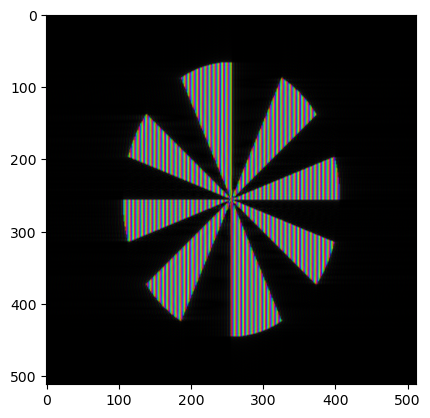

In [27]:
# inverse Fresnel 
plt.imshow(colorize(field_bwd, gamma=1.0))

In [15]:
print(np.squeeze(field_exit.dx))

print(np.sum(field_exit.intensity))
print(np.sum(field_sensor.intensity))
print(np.sum(field_backpropagated.intensity))

print(np.sum(field_sensor_fr.intensity))
print(np.sum(field_bwd.intensity))


[0.25 0.25]
1024.0
15.3354225
981.21985
15.506985
992.35846
